# 1. Get Data

In [234]:
import torch
import torch.nn
import torchvision
import torchvision.transforms as transforms

In [235]:
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo. Downloading...")
  !pip -q install torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular.going_modular. Downloading...")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

In [236]:
def download_data(source, destination, remove_source : bool = True):
  import requests
  import pathlib
  import zipfile
  import os

  data_path = pathlib.Path("data/")
  image_path = data_path / destination

  if image_path.is_dir():
    print(f"[INFO] {image_path} directory exists, skipping download.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents = True, exist_ok = True)

    target_file = pathlib.Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      f.write(request.content)

    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    if remove_source:
            os.remove(data_path / target_file)

  return image_path

In [237]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
             destination = "pizza_steak_sushi")

image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [238]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create Datasets and DataLoaders

In [239]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [240]:
import os
def create_dataLoader(train_dir,
                      test_dir,
                      transforms,
                      batch_size,
                      num_workers : int = os.cpu_count()):

  train_data = torchvision.datasets.ImageFolder(train_dir, transforms)
  test_data = torchvision.datasets.ImageFolder(test_dir, transforms)
  classes = train_data.classes
  train_dataLoader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
  test_dataLoader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)
  return train_dataLoader, test_dataLoader, classes

In [241]:
train_dataLoader, test_dataLoader, classes = create_dataLoader(train_dir = train_dir,
                                                              test_dir = test_dir,
                                                              transforms = manual_transforms,
                                                              batch_size = 32)
train_dataLoader, test_dataLoader, classes

(<torch.utils.data.dataloader.DataLoader at 0x784ae7b8c250>,
 ['pizza', 'steak', 'sushi'])

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

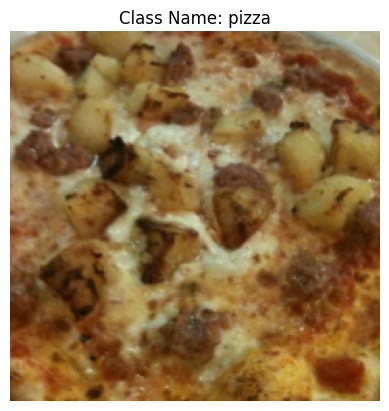

In [242]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_dataLoader))
image, label = images[0], labels[0]
image.shape
plt.imshow(image.permute(1,2,0))
plt.title(f"Class Name: {classes[label]}")
plt.axis(False)

# 3. Replicating the ViT paper

#### Equation 1 overview
(1) x_input = [class_token + image_patch_1, image_patch_2, ..., image_path_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_path_poss_N]

#### Equation 2 overview

(2) x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

#### Equation 3 overview

(3) x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

#### Equation 4 overview

MLP -> multilayer perceptron = a neural network with X number of layers
MLP -> one hidden layer at training time
MLP -> single linear layer at fine-tuning time

(4) y = Linear_Layer(LN_layer(x_output_MLP_block[0]))



* Layers          -> the number of transformer encoder layers
* Hidden Size $D$ -> the embedding size throughout the architecture
* MLP Size        -> the number of hidden units/neurons in the MLP
* Head            -> the number of multi-head self-attention



$D$ is the size of the patch embeddings, different values for $D$ for various sized ViT models.

The image starts as 2D with size ${H \times W \times C}$.

$(H, W)$ is the resolution of the original image (height, width).

$C$ is the number of channels.

The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

$(P, P)$ is the resolution of each image patch (patch size).

$N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

## Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

* Input Shape : (224, 224, 3) -> single image -> (height, width, color channels)
* Output Shape :
**Equation 1**
 The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = HW/P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input Shape: $H\times{W}\times{C}$ (height X width X color_channels)
* Output Shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / P^2
* D = constant latent vector size = embedding dimension

In [243]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int(height * width / patch_size ** 2)
number_of_patches

196

In [244]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

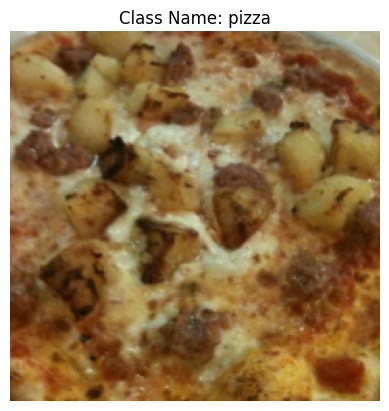

In [245]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Class Name: {classes[label]}")
plt.axis(False)

In [246]:
image.shape

torch.Size([3, 224, 224])

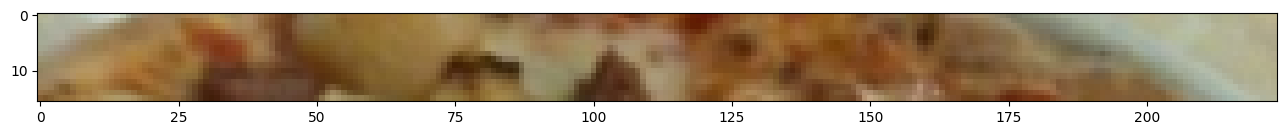

In [247]:
permuted_image = image.permute(1, 2, 0) # permuted_image.shape (224, 224, 3)
patch_size = 16
# get the top row of image
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(permuted_image[ : patch_size, :, :]) # [height, width, color_channels]

Number of patches per row: 14
Patch Size: 16 pixels x 16 pixels


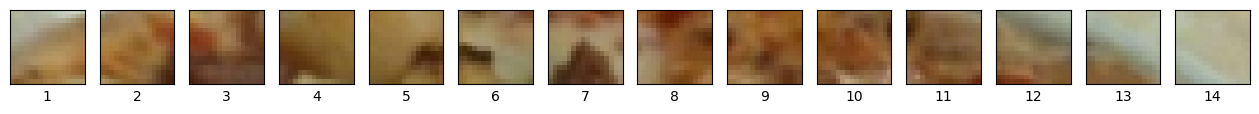

In [248]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
print(f"Number of patches per row: {num_patches}\nPatch Size: {patch_size} pixels x {patch_size} pixels")
permuted_image = image.permute(1, 2, 0)

fig, axes = plt.subplots(nrows = 1,
                         ncols = num_patches,
                         sharex = True,
                         sharey = True,
                         figsize = (patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
  axes[i].imshow(permuted_image[:patch_size, patch:patch_size+patch, :])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

Text(0.5, 0.98, 'pizza')

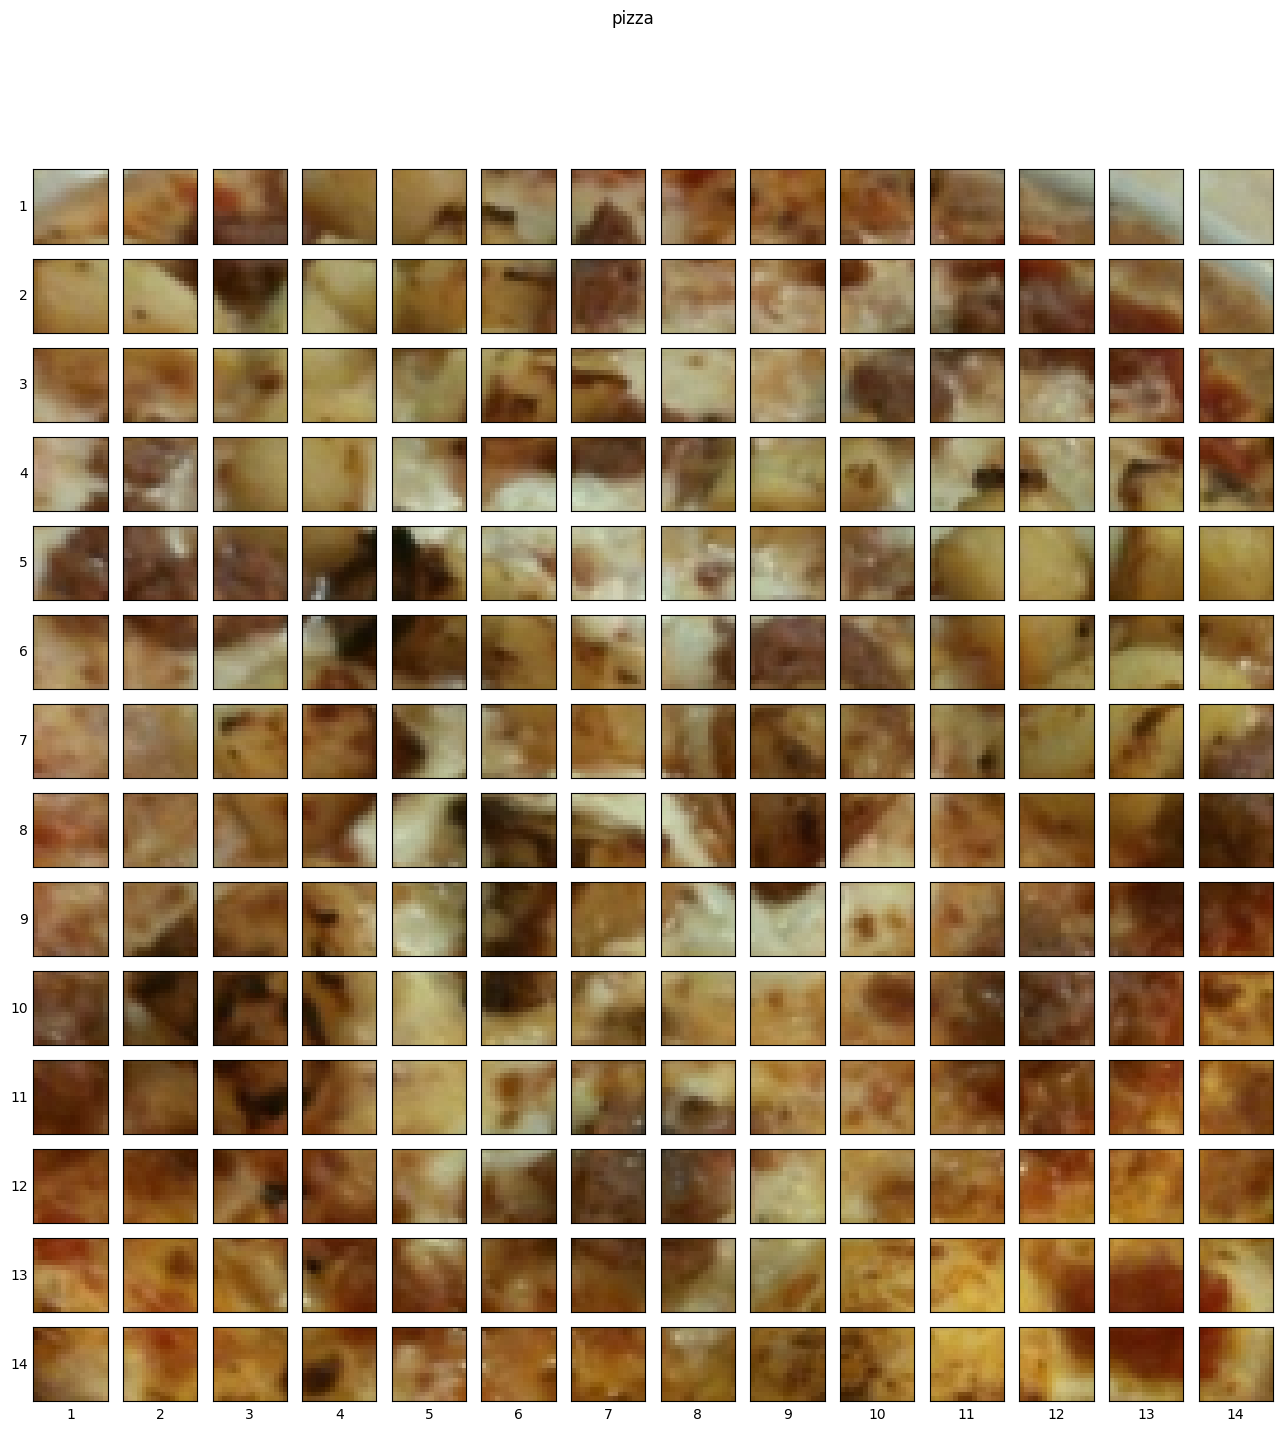

In [249]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
permuted_image = image.permute(1, 2, 0)

fig, axes = plt.subplots(nrows = num_patches,
                         ncols = num_patches,
                         sharex = True,
                         sharey = True,
                         figsize = (patch_size, patch_size))

for i, x_patch in enumerate(range(0, img_size, patch_size)):
  for j, y_patch in enumerate(range(0, img_size, patch_size)):
    axes[i, j].imshow(permuted_image[x_patch:patch_size+x_patch, y_patch:patch_size+y_patch, :])
    axes[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
    axes[i, j].set_xlabel(j+1)
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j].label_outer()
fig.suptitle(classes[label])

#### Creating Patch Embeddings with a CNN

In [250]:
import torch.nn as nn
conv2d = nn.Conv2d(
    in_channels = 3,           # for color images
    out_channels = 768,        # D size
    kernel_size = patch_size,
    stride = patch_size,
    padding = 0
)

In [251]:
image.shape

torch.Size([3, 224, 224])

In [252]:
image_out_of_conv = conv2d(image.unsqueeze(dim = 0))
image_out_of_conv.shape # [batch_size, embedding_dim, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])

Random indexes: [48, 225, 488, 254, 281]


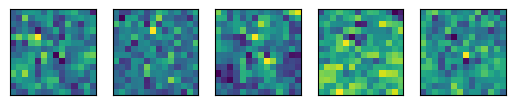

In [253]:
import random
random_idx = random.sample(range(0, 768), k = 5)
print(f"Random indexes: {random_idx}")

fig, axes = plt.subplots(nrows = 1, ncols = 5, sharex = True, sharey = True)
for i, idx in enumerate(random_idx):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # [batch_size, embedding_dim, feature_map_height, feature_map_width]
  axes[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axes[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Desired output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

In [254]:
print(f"Image feature map shape: {image_out_of_conv.shape}") # [batch_size, embedding_dim, feature_map_height, feature_map_width]

Image feature map shape: torch.Size([1, 768, 14, 14])


In [255]:
flatten = nn.Flatten(start_dim = 2, end_dim = 3)
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


Output shape (single 1D sequence of patches) : (196, 768)

In [256]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

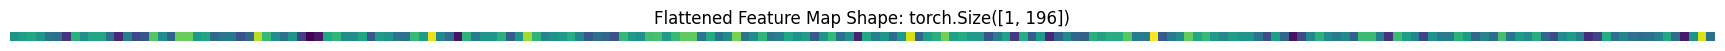

In [257]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, : , 0]
plt.figure(figsize = (22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened Feature Map Shape: {single_flattened_feature_map.shape}")
plt.axis(False)

Summary (setting shape)

Original Shape: torch.Size([3, 224, 224])
Convoluted Image Shape: torch.Size([1, 768, 14, 14])
Flattened Image Shape: torch.Size([1, 768, 196])


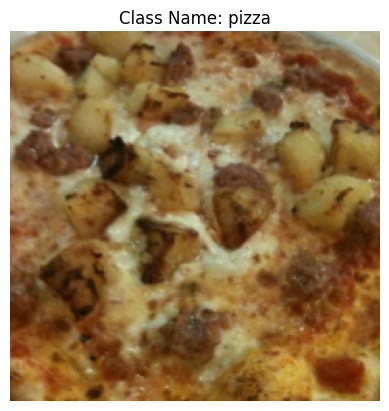

In [258]:
plt.imshow(image.permute(1,2,0))
plt.title(f"Class Name: {classes[label]}")
plt.axis(False)

print(f"Original Shape: {image.shape}")

image_conv = conv2d(image.unsqueeze(0))
print(f"Convoluted Image Shape: {image_conv.shape}")

embedded_image = flatten(image_conv)
print(f"Flattened Image Shape: {embedded_image.shape}")

Turning the ViT patch embedding layer into a PyTorch module

In [259]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels : int = 3, patch_size : int = 16 ,embedding_dim : int = 768):
    super().__init__()
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)

    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

    self.patch_size = patch_size

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert  image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

In [260]:
patchify = PatchEmbedding()
print(f"Image Shape: {image.shape}")
patch_embedded_image = patchify(image.unsqueeze(dim = 0)) # add an extra batch dimension on the 0th index,
print(f"Patch Embedded Image Shape: {patch_embedded_image.shape}")

Image Shape: torch.Size([3, 224, 224])
Patch Embedded Image Shape: torch.Size([1, 196, 768])


The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

Input: The image starts as 2D with size ${H \times W \times C}$.

Output: The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
Where:

$(H, W)$ is the resolution of the original image.

$C$ is the number of channels.
$(P, P)$ is the resolution of each image patch (patch size).

$N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

create a class token embedding

In [261]:
class_token = nn.Parameter(torch.ones(1, 1, 768), requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [262]:
"""
 [batch, patch/token, embedding_dim]
[  1  ,   196     ,   768         ]  ← patch_embedded_image
[  1  ,   1       ,   768         ]  ← class_token

dim = 1 -> sum of patches
"""

patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim = 1)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


* $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".

Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$  
* (+1 is for the class token)

In [263]:
number_of_patches = int((height * width) / patch_size ** 2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)
print(f"Position Embedding Shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Position Embedding Shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [264]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Total Summary

In [265]:
image.shape

torch.Size([3, 224, 224])

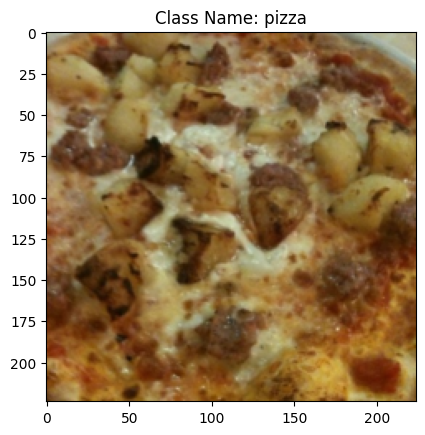

In [266]:
plt.title(f"Class Name: {classes[label]}")
plt.imshow(image.permute(1, 2, 0)) # shape -> [224, 224, 3] : [height, width, color_channels]

In [267]:
patch_size = 16
height, width = image.shape[1], image.shape[2]
height, width, patch_size

image_with_batchsize = image.unsqueeze(dim = 0)
print(f"Input image with batch dimension shape: {image_with_batchsize.shape}")

patch_embedding_layer = PatchEmbedding(in_channels = 3, patch_size = patch_size, embedding_dim = 768)
patch_embedding = patch_embedding_layer(image_with_batchsize)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
patch_embedding_class_token.shape
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

num_of_patch = int((height* width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, num_of_patch + 1, embedding_dimension), requires_grad=True)
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


* Equation 2 : Multi-Head Self-Attention (MSA Block)

In [268]:
class MultiheadSelfAttention(nn.Module):
  def __init__(self, embedding_dimension : int = 768, num_heads : int = 12, attn_dropout:float=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dimension)
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dimension,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True) # (batch, seq, feature) -> (batch_size, number_of_patches, embedding_dimension)


  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x, key = x, value = x, need_weights = False)
    return attn_output

In [269]:
multihead_self_attention_block = MultiheadSelfAttention(embedding_dimension=768,
                                                        num_heads=12,
                                                        attn_dropout=0)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


MultiLayer Perceptron : MLP Block

**MLP** = The MLP contains two layers with a GeLU non-linearity

  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.

  * In PyTorch, they are often called `torch.nn.Linear()`

  * MLP number of hidden units = MLP size

  x = linear -> non-linear -> droput -> linear -> non-linear

In [270]:
class MLP_Block(nn.Module):
  def __init__(self,
               embedding_dimension : int = 768,
               mlp_size : int = 3072,
               dropout : int = 0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dimension)
    self.mlp_block = nn.Sequential(
        nn.Linear(in_features = embedding_dimension, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dimension),
        nn.Dropout(p = dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp_block(x)
    return x

In [271]:
mlp_block = MLP_Block(embedding_dimension = 768,
                      mlp_size = 3072,
                      dropout = 0.1)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

In [272]:
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [273]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embedded_image : int = 768, num_heads : int = 12, attn_dropout = 0, mlp_size = 3072, mlp_dropout = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)

    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dimension,
                              num_heads = num_heads,
                              dropout = attn_dropout,
                              batch_first = True)

    self.mlp_block = nn.Sequential(
        nn.Linear(in_features = embedding_dimension, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dimension),
        nn.Dropout(p = mlp_dropout)
    )
  def forward(self, x):
    layer_norm_1 = self.layer_norm(x)
    msa, _ = self.multihead_attn(query = layer_norm_1, key = layer_norm_1, value = layer_norm_1, need_weights = False)
    first_residual = msa + x
    layer_norm_2 = self.layer_norm(first_residual)
    mlp = self.mlp_block(layer_norm_2)
    result = first_residual + mlp
    return result


In [274]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model = transformer_encoder_block,
        input_size = (1, 197, 768), # (batch_size, num_of_patch, embedding_dim)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (multihead_attn)              --                   [1, 197, 768]        2,362,368            True
├─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        (recursive)          True
├─Sequential (mlp_block)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Linear (0)                                  [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    └─GELU (1)                                    [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Dropout (2)                           

In [275]:
# Creating a Transformer Encoder with PyTorch's Transform Layers
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                          nhead = 12,
                          dim_feedforward = 3072,
                          dropout = 0.1,
                          activation = "gelu",
                          batch_first = True,
                          norm_first = True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [276]:
summary(model = torch_transformer_encoder_layer,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

# Total Summary

In [277]:
# like data preprocessing
print(f"Image Shape: {image.shape}")
print(f"Image Shape: {image.permute(1, 2, 0).shape} -> [height, width, color_channels]")

height = image.permute(1, 2, 0).shape[0]
width = image.permute(1, 2, 0).shape[1]
color_channels = image.permute(1, 2, 0).shape[2]
print(f"Height: {height}, Width: {width}")

patch_size = 16
number_of_patches = int(height * height / patch_size ** 2)
print(f"Number of patches : {number_of_patches} -> (height * height / patch_size ** 2)")

embedding_dimension = ((patch_size ** 2) * color_channels)
print(f"Embedding Dimension: {embedding_dimension} -> [(number of patches), ((height * width) * color_channels)] : [N, P**2*C]")
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, embedding_dimension)
print(f"Input Shape (single 2D image): {embedding_layer_input_shape} -> [height, width, color_channels]")
print(f"Output Shape  (single 2D image flattened into patches): {embedding_layer_output_shape} -> [number_of_patches, embedding_dimension]")

Image Shape: torch.Size([3, 224, 224])
Image Shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]
Height: 224, Width: 224
Number of patches : 196 -> (height * height / patch_size ** 2)
Embedding Dimension: 768 -> [(number of patches), ((height * width) * color_channels)] : [N, P**2*C]
Input Shape (single 2D image): (224, 224, 3) -> [height, width, color_channels]
Output Shape  (single 2D image flattened into patches): (196, 768) -> [number_of_patches, embedding_dimension]


In [278]:
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector."""
  def __init__(self, in_channels : int = 3, patch_size : int = 16, embedding_dimension : int = 768):
    super().__init__()
    self.conv2d = nn.Conv2d(in_channels = in_channels,
                            out_channels = embedding_dimension,
                            kernel_size = patch_size,
                            stride = patch_size,
                            padding = 0)

    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

  def forward(self, x):
    return self.flatten(self.conv2d(x)).permute(0, 2, 1)

patch_embedding = PatchEmbedding()
print(f"Input Image Shape: {image.unsqueeze(dim = 0).shape} -> [batch_size, color_channels, height, width]")
patch_embedded_image = patch_embedding(image.unsqueeze(dim = 0))
print(f"Output Image Shape: {patch_embedded_image.shape} -> [batch_size, number of patches, embedding_dimension]")

Input Image Shape: torch.Size([1, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Output Image Shape: torch.Size([1, 196, 768]) -> [batch_size, number of patches, embedding_dimension]


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

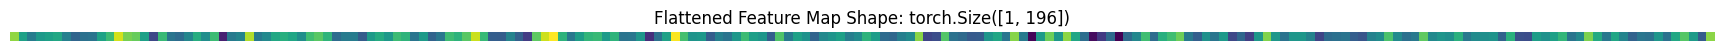

In [279]:
single_flattened_patch_embedded_image = patch_embedded_image[:, :, 0]
plt.figure(figsize = (22, 22))
plt.imshow(single_flattened_patch_embedded_image.detach().numpy())
plt.title(f"Flattened Feature Map Shape: {single_flattened_patch_embedded_image.shape}")
plt.axis(False)

In [280]:
random_input_image = (1, 3, 224, 224)
summary(PatchEmbedding(),
        input_size = random_input_image,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (conv2d)                        [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [281]:
# creating a learnable class token embedding
class_token = nn.Parameter(torch.randn(batch_size, batch_size, embedding_dimension), requires_grad = True)
patch_embedded_image.shape, class_token.shape

(torch.Size([1, 196, 768]), torch.Size([1, 1, 768]))

In [282]:
"""
 [batch, patch/token, embedding_dim]
[  1  ,   196     ,   768         ]  ← patch_embedded_image
[  1  ,   1       ,   768         ]  ← class_token

dim = 1 -> sum of patches
"""
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim = 1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [283]:
# creating a learnable position embedding
position_embedding = nn.Parameter(torch.randn(batch_size, number_of_patches+1, embedding_dimension), requires_grad = True)

In [284]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

# MSA (Multi Head Attention)

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

Multi-Head Self Attention (MSA) - torch.nn.MultiheadAttention().

Norm (LN or LayerNorm) - torch.nn.LayerNorm().

Residual connection - add the input to output


In [285]:
class MSA_Block(nn.Module):
  def __init__(self, embedding_dimension : int = 768, num_heads : int = 12, attn_dropout : float = 0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dimension)
    self.msa_block = nn.MultiheadAttention(embed_dim = embedding_dimension,
                                           num_heads = num_heads,
                                           dropout = attn_dropout,
                                           batch_first = True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.msa_block(query = x, key = x, value = x, need_weights = False)
    return attn_output

In [286]:
msa_block = MSA_Block()
patched_image_through_msa_block = msa_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# MLP Multilayer Perceptron (MLP)

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \end{aligned} $$

x = linear -> non-linear -> droput -> linear -> non-linear

In [287]:
class MLP_Block(nn.Module):
  def __init__(self, embedding_dimension : int = 768, mlp_size = 3072, dropout : float = 0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dimension)
    self.mlp_block = nn.Sequential(
        nn.Linear(in_features = embedding_dimension,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dimension),
        nn.Dropout(p = dropout)
    )

  def forward(self, x):
    return self.mlp_block(self.layer_norm(x))

In [288]:
mlp_block = MLP_Block()
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [289]:
# Create TransformerEncoder
class TransformerEncoder_Block(nn.Module):
  def __init__(self, embedding_dimension : int = 768, num_heads : int = 12, mlp_size : int = 3072, attn_dropout : float = 0, dropout : float = 0.1):
    super().__init__()
    self.msa_block = MSA_Block(embedding_dimension, num_heads, attn_dropout)
    self.mlp_block = MLP_Block(embedding_dimension, mlp_size, dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [290]:
transformer_encoder_block = TransformerEncoder_Block()
summary(transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoder_Block (TransformerEncoder_Block)     [1, 197, 768]        [1, 197, 768]        --                   True
├─MSA_Block (msa_block)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa_block)                   --                   [1, 197, 768]        2,362,368            True
├─MLP_Block (mlp_block)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_block)                           [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [291]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)